# ECG study case #

In [1]:
# Modules
import requests
import websocket
import time
from datetime import datetime
import pandas as pd
import threading
import yaml
import numpy as np

# Modules for visualization 
import bokeh
from bokeh.models import ColumnDataSource
from bokeh.io import curdoc
from bokeh.plotting import figure
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Modules for statistical analysis
import neurokit2 as nk

%matplotlib notebook 

## Part I: a working client for streaming data ##

In [2]:
# WebSocket server URL
ws_url = "ws://assemblix:8282"

# Empty lists to store data
x_data = [] # ECG I
y_data = [] # ECG I filtered
ts = []

### WebSocket ###

In [3]:
# Functions to handle WebSocket

# Function to handle received data
def on_message(ws, message):
    '''
    Split message, convert the data type and add to a list
    '''
    # print (message)
    
    data = message.split(',')
    print (data)
    try:
        ts_val = datetime.strptime(data[0].split()[2], '%H:%M:%S.%f')
        x_val = float(data[1])
        y_val = float(data[2])
    except:
        print (f'{message} could not be parsed')

    # Append the received values to the data lists
    ts.append(ts_val)
    x_data.append(x_val)
    y_data.append(y_val)

    # Check whether there are 500 data point in the list
    if len(ts) > 1000:
        ts.pop(0)
        x_data.pop(0)
        y_data.pop(0)
              

# Function to handle WebSocket open
def on_open(ws):
    print("Connected to WebSocket server")

# Function to handle WebSocket close
def on_close(ws):
    print("Connection to WebSocket server closed")

# WebSocket connection
def run_websocket():
    ws = websocket.WebSocketApp(ws_url,
                                on_message=on_message,
                                on_open=on_open,
                                on_close=on_close)
    ws.run_forever()

# Function to update the plot
def update(frame):
    # Clear previous plot
    plt.cla()
    # Plot the data
    plt.plot(ts, y_data, label='ECG I')
    plt.plot(ts, x_data, label='ECG I filtered')
    plt.ylim(-0.3, 1)
    # Set plot title and labels
    plt.title('ECG Plot')
    plt.xlabel('Time (ms)')
    plt.ylabel('ECG (mV)')
    plt.legend(loc='best')

<IPython.core.display.Javascript object>


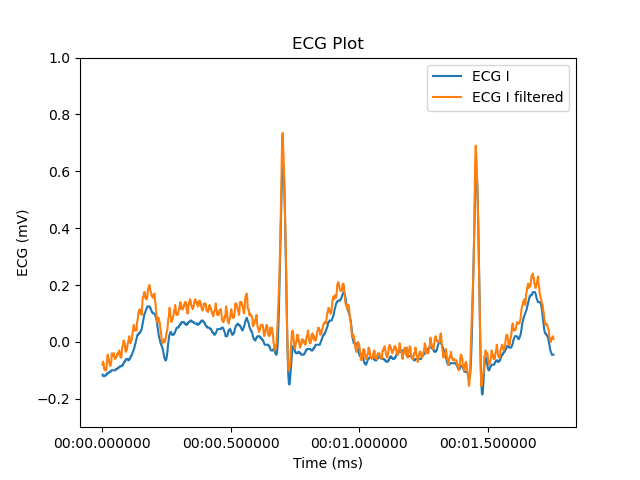

Connected to WebSocket server


/tmp/ipykernel_399089/3354516280.py:9: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=1000) # Update plot every 1000 milliseconds (1 second)


In [4]:
# Start WebSocket connection in a separate thread
websocket_thread = threading.Thread(target=run_websocket)
websocket_thread.start()

# plotting
fig, ax = plt.subplots()

# Create an animation
ani = FuncAnimation(fig, update, interval=1000) # Update plot every 1000 milliseconds (1 second)

# Show the plot
plt.show()

#websocket_thread.join()
#print('all threads are finished')

## Part II: Extract features and perform analysis ##

In [5]:
len(y_data)

['0 days 00:00:02', '-0.045', '-0.105']
0 days 00:00:02,-0.045,-0.105 could not be parsed


998

['0 days 00:00:02.002000', '-0.045', '-0.11']
['0 days 00:00:02.004000', '-0.045', '-0.11']
['0 days 00:00:02.006000', '-0.035', '-0.115']
['0 days 00:00:02.008000', '-0.04', '-0.12']
['0 days 00:00:02.010000', '-0.025', '-0.12']
['0 days 00:00:02.012000', '-0.01', '-0.125']
['0 days 00:00:02.014000', '-0.025', '-0.12']
['0 days 00:00:02.016000', '-0.04', '-0.12']
['0 days 00:00:02.018000', '-0.04', '-0.11']
['0 days 00:00:02.020000', '-0.03', '-0.105']
['0 days 00:00:02.022000', '-0.035', '-0.1']
['0 days 00:00:02.024000', '-0.04', '-0.095']
['0 days 00:00:02.026000', '-0.025', '-0.09']
['0 days 00:00:02.028000', '-0.02', '-0.095']
['0 days 00:00:02.030000', '-0.015', '-0.1']
['0 days 00:00:02.032000', '-0.005', '-0.105']
['0 days 00:00:02.034000', '-0.01', '-0.11']
['0 days 00:00:02.036000', '-0.025', '-0.115']
['0 days 00:00:02.038000', '-0.04', '-0.12']
['0 days 00:00:02.040000', '-0.045', '-0.12']
['0 days 00:00:02.042000', '-0.04', '-0.12']
['0 days 00:00:02.044000', '-0.02', '-0

In [6]:
ecg_filtered = np.array(y_data)

['0 days 00:00:02.248000', '0.175', '0.04']
['0 days 00:00:02.250000', '0.235', '0.09']
['0 days 00:00:02.252000', '0.28', '0.155']
['0 days 00:00:02.254000', '0.325', '0.23']
['0 days 00:00:02.256000', '0.385', '0.31']
['0 days 00:00:02.258000', '0.445', '0.4']
['0 days 00:00:02.260000', '0.555', '0.49']
['0 days 00:00:02.262000', '0.68', '0.575']
['0 days 00:00:02.264000', '0.82', '0.65']
['0 days 00:00:02.266000', '0.89', '0.705']
['0 days 00:00:02.268000', '0.86', '0.735']
['0 days 00:00:02.270000', '0.84', '0.735']
['0 days 00:00:02.272000', '0.775', '0.705']
['0 days 00:00:02.274000', '0.695', '0.64']
['0 days 00:00:02.276000', '0.595', '0.55']
['0 days 00:00:02.278000', '0.505', '0.44']
['0 days 00:00:02.280000', '0.395', '0.32']
['0 days 00:00:02.282000', '0.265', '0.205']
['0 days 00:00:02.284000', '0.155', '0.1']
['0 days 00:00:02.286000', '0.05', '0.015']
['0 days 00:00:02.288000', '0.01', '-0.045']
['0 days 00:00:02.290000', '0.035', '-0.075']
['0 days 00:00:02.292000', '0.

In [ ]:
_, rpeaks = nk.ecg_peaks(ecg_filtered, sampling_rate=1000)

In [ ]:
# Zooming into the first 5 R-peaks
plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:1], ecg_filtered[:500])

In [ ]:
# Delineate the ECG signal
_, waves_peak = nk.ecg_delineate(ecg_filtered, rpeaks, sampling_rate=100, method="peak")

In [ ]:
# Zooming into the first 3 R-peaks, with focus on T_peaks, P-peaks, Q-peaks and S-peaks
plot = nk.events_plot([waves_peak['ECG_T_Peaks'][:3], 
                       waves_peak['ECG_P_Peaks'][:3],
                       waves_peak['ECG_Q_Peaks'][:3],
                       waves_peak['ECG_S_Peaks'][:3]], ecg_signal[:4000])

In [ ]:
# Delineate the ECG signal and visualizing all peaks of ECG complexes
_, waves_peak = nk.ecg_delineate(ecg_signal, 
                                 rpeaks, 
                                 sampling_rate=1000, 
                                 method="peak", 
                                 show=True, 
                                 show_type='peaks')

In [ ]:
# Retrieve ECG data from data folder
ecg_signal = nk.data(dataset="ecg_1000hz")
# Extract R-peaks locations
_, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=1000)

In [ ]:
ecg_signal

In [ ]:
ecg_signal.shape

In [ ]:
# Visualize R-peaks in ECG signal
plot = nk.events_plot(rpeaks['ECG_R_Peaks'], ecg_signal)

In [ ]:
# Zooming into the first 5 R-peaks
plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:5], ecg_signal[:6000])

In [ ]:
# Delineate the ECG signal
_, waves_peak = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=1000, method="peak")

In [ ]:
# Zooming into the first 3 R-peaks, with focus on T_peaks, P-peaks, Q-peaks and S-peaks
plot = nk.events_plot([waves_peak['ECG_T_Peaks'][:3], 
                       waves_peak['ECG_P_Peaks'][:3],
                       waves_peak['ECG_Q_Peaks'][:3],
                       waves_peak['ECG_S_Peaks'][:3]], ecg_signal[:4000])

In [ ]:
# Delineate the ECG signal and visualizing all peaks of ECG complexes
_, waves_peak = nk.ecg_delineate(ecg_signal, 
                                 rpeaks, 
                                 sampling_rate=1000, 
                                 method="peak", 
                                 show=True, 
                                 show_type='peaks')